In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import torchvision.transforms.functional as tvtf
import json
from tqdm.notebook import tqdm

import sys; sys.path.append("../src")
from prompts.explanations import *
from cholec import CholecExample, CholecDataset, load_model, items_to_examples
from llms import image_to_base64

/home/antonxue/lib/miniconda3/envs/tfl/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/antonxue/lib/miniconda3/envs/tfl/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/antonxue/lib/miniconda3/envs/tfl/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
llm = load_model("claude-3-5-sonnet-latest")
# llm = load_model("gemini-2.5-pro-exp-03-25")
# llm = load_model("gemini-2.0-flash")

In [3]:
dataset = CholecDataset(split="train", image_size=(360,640))
items = []
for i, item in enumerate(dataset):
    if i % 5 != 0:
        continue

    if (item["gonogo"] == 1).float().mean() > 0.05 and (item["gonogo"] == 2).float().mean() > 0.05:
        items.append(item)

    if len(items) >= 10:
        break

/home/antonxue/lib/miniconda3/envs/tfl/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [4]:
prompt_header = """
You are an expert surgeon with extensive experience in laparoscopic cholecystectomy.
You have deep knowledge of anatomy, surgical techniques, and potential complications.
Your task is to provide an explanation of where it is safe and unsafe to cut based on an image and a list of numbers.
These numbers correspond to a discretization of the image into a 9-high x 16-wide grid.
- The top-left corner is index 0.
- The top-right corner is index 15.
- The bottom-left corner is index 128.
- The bottom-right corner is index 143.

I will give you an example.
"""

In [5]:
grid_size = 40
image_size = dataset.image_size
print(image_size, grid_size)

(360, 640) 40


In [6]:
for i, item in tqdm(enumerate(items)):
    image = item["image"]
    safe = (item["gonogo"] == 1).long()
    unsafe = (item["gonogo"] == 2).long()

    a2d = nn.AvgPool2d(kernel_size=grid_size, stride=grid_size, padding=0)
    safe_rough = (a2d(safe.float()).squeeze() > 0.1).long()
    unsafe_rough = (a2d(unsafe.float()).squeeze() > 0.1).long()

    safe_list = safe_rough.view(-1).nonzero().view(-1).tolist()
    unsafe_list = unsafe_rough.view(-1).nonzero().view(-1).tolist()
    
    safe_rough_big = F.interpolate(safe_rough.float().view(1,1,9,16), size=image_size).view(image_size)
    unsafe_rough_big = F.interpolate(unsafe_rough.float().view(1,1,9,16), size=image_size).view(image_size)

    explanation = llm((
        prompt_header,
        "Here is the surgery image", image,
        "Here are the grid indices of the safe region: " + str(safe_list),
        "These grid indices correspond to the following mask: ", safe_rough_big,
        "Here are the grid indices of the unsafe region: " + str(unsafe_list),
        "These grid indices correspond to the following mask: ", unsafe_rough_big,
        """Please give me a 300-500 word description of both regions using the image.
        Do not refer to the mask or given indices.
        Your job is to generate an explanation that will be used as part of an LLM prompt.
        That LLM will only be able to see the original surgery image.
        Be concise in your output. Identify only the safe and unsafe regions.
        Do not output broadly general surgical advice.
        """
    ))

    # explanation = ""
    
    path_prefix = f"cholec_fewshot_{i+1}"
    with open(f"_dump/{path_prefix}_data.json", "w") as f:
        json.dump({
            "id": item["id"],
            "explanation": explanation,
            "safe": safe_list,
            "unsafe": unsafe_list,
        }, f, indent=4)

    save_image(image, f"_dump/{path_prefix}_image.png")
    save_image(safe_rough_big, f"_dump/{path_prefix}_safe.png")
    save_image(unsafe_rough_big, f"_dump/{path_prefix}_unsafe.png")

0it [00:00, ?it/s]

In [7]:
print("Safe", safe_list)
print("Unsafe", unsafe_list)
print(explanation)

Safe [5, 6, 7, 21, 22, 23, 37, 38, 39, 53, 54, 55, 68, 69, 70, 84, 85, 86]
Unsafe [42, 43, 44, 45, 57, 58, 59, 60, 61, 62, 72, 73, 74, 75, 76, 77, 78, 87, 88, 89, 90, 91, 92, 93, 94, 102, 103, 104, 105, 106, 107, 108, 109, 110, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]
In this laparoscopic cholecystectomy image, I can clearly identify the safe and unsafe regions for dissection.

The safe region is located in the upper portion of the image, appearing as a vertical strip along what appears to be the cystic duct. This area shows clearer tissue planes and is relatively free from major vascular structures. The safe dissection zone extends downward in a columnar fashion from the superior aspect of the visible field, encompassing an area where the tissue appears more translucent and less vascularized.

The unsafe region encompasses a larger area in the lower two-thirds of the image, extending diagonally from th

<Figure size 640x480 with 0 Axes>

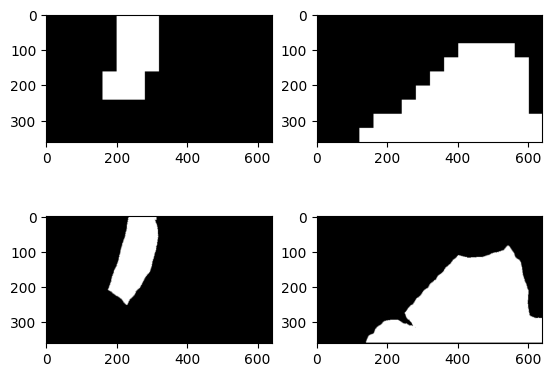

In [8]:
plt.clf()
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(safe_rough_big.squeeze().numpy(), cmap="gray")
ax[1,0].imshow(safe.squeeze().numpy(), cmap="gray")
ax[0,1].imshow(unsafe_rough_big.squeeze().numpy(), cmap="gray")
ax[1,1].imshow(unsafe.squeeze().numpy(), cmap="gray")